# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio
import jax

import mrcfile

plt.rcParams["figure.figsize"]=8,8

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
star_file = "/Extract/job018/particles.star"

params0, imgs_f0 = load_data(data_dir, star_file, True)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  4501
load_data: data loaded, time:  4.794729948043823
load_data: FFT of data, time:  8.017106056213379


In [4]:
print(imgs_f0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(4501, 256, 256)
(4501,)
(4501, 3)
(4501, 2)
(4501, 9)


### Only keep the first N points (to avoid out of memory error)

In [5]:
N = 10000
imgs_f = imgs_f0[:N]
pixel_size = pixel_size0[:N]
angles = angles0[:N]
shifts = shifts0[:N]
ctf_params = ctf_params0[:N]

### Some angle filtering

In [6]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Create the grids

In [7]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 2.56000000e+02]


### Crop images to 32 x 32 

In [8]:
nx = 32
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 3.20000000e+01]


### Before further processing, vectorize the images, create mask etc

In [9]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(4501, 1024)


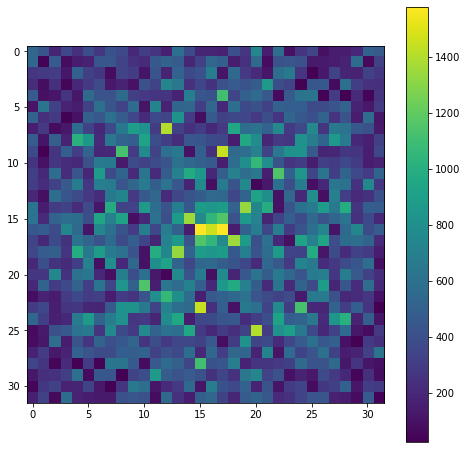

In [10]:
plt.imshow(jnp.abs(jnp.fft.fftshift(jnp.array(imgs_f[101].reshape(nx,nx)))));plt.colorbar()

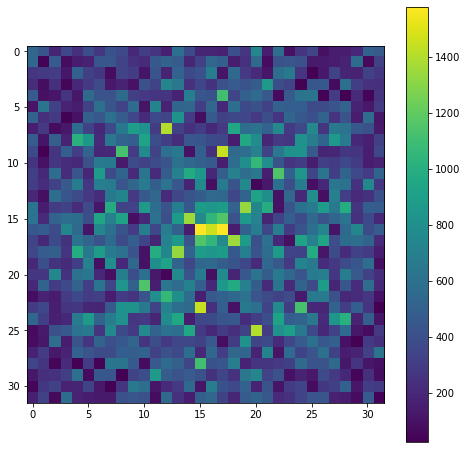

In [11]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

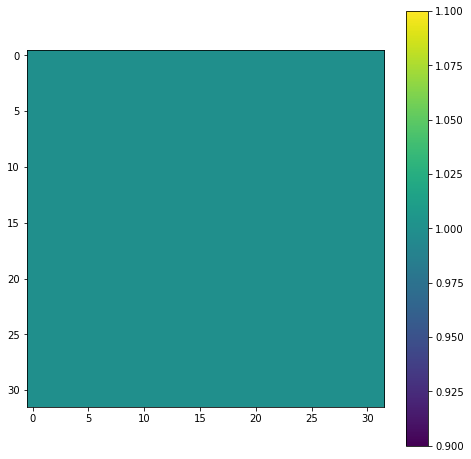

In [12]:
centre = (0,0,0)
#radius = 0.07 # for nx=64
#radius = 0.14 # for nx=128
radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)


mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Forward model and loss functon

In [13]:
alpha = 0.1

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

Test the functions above with a random volume

In [14]:
vf = jnp.array(np.random.randn(nx,nx,nx))
sf = slice_func(vf, angles[0], shifts[0], ctf_params[0])
sf.shape

(1024,)

In [15]:
start = time.time()
ll = grad_loss_volume(vf, angles[0], shifts[0], ctf_params[0], imgs_f[0])
print(time.time()-start)
print(ll.shape)

1.5097198486328125
(32, 32, 32)


In [16]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vf, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx])
print(time.time()-start)
print(ll.shape)

1.7878351211547852
(32, 32, 32)


### Ab initio

In [17]:
x_grid[0]*x_grid[1]/2

0.05021972132474

In [18]:
x_grid[0]

0.00313873258279625

  sgd epoch 0: mean sampled gradient = 0.00020937804859648908
  sgd epoch 50: mean sampled gradient = 7.490457020391563e-06
  sgd epoch 100: mean sampled gradient = 1.0866046195977823e-05
  sgd epoch 150: mean sampled gradient = 5.4382901258578146e-06


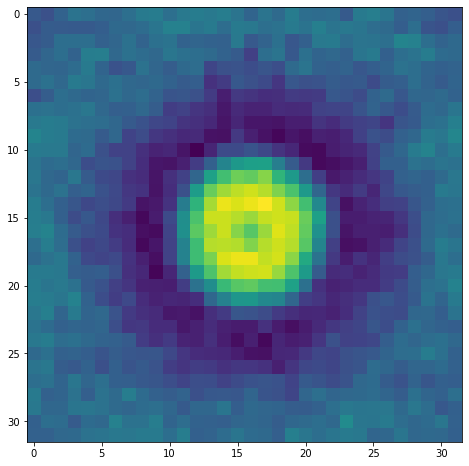

Iter  0
  Time orientations sampling = 1.7313227653503418
  sgd epoch 0: mean sampled gradient = 0.031146463050140797
  sgd epoch 50: mean sampled gradient = 0.0003694416934477151
  sgd epoch 100: mean sampled gradient = 2.9152982597175176e-05
  sgd epoch 150: mean sampled gradient = 0.0003640049581789114
  Time vol optimisation = 9.639461278915405
  nx = 8


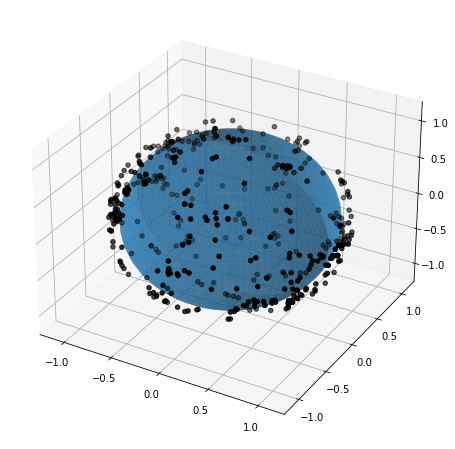

Iter  1
  Time orientations sampling = 1.705113172531128
  sgd epoch 0: mean sampled gradient = 0.008734920096929853
  sgd epoch 50: mean sampled gradient = 0.0005151950410375559
  sgd epoch 100: mean sampled gradient = 0.0001390891970527366
  sgd epoch 150: mean sampled gradient = 0.0005830046207099991
  Time vol optimisation = 10.037203311920166
Iter  2
  Time orientations sampling = 1.7290410995483398
  sgd epoch 0: mean sampled gradient = 0.008569803179873665
  sgd epoch 50: mean sampled gradient = 0.0005842505865520599
  sgd epoch 100: mean sampled gradient = 0.00019639622062794616
  sgd epoch 150: mean sampled gradient = 0.00022192357591547523
  Time vol optimisation = 9.04238224029541
Iter  3
  Time orientations sampling = 1.743464469909668
  sgd epoch 0: mean sampled gradient = 0.008652684015451322
  sgd epoch 50: mean sampled gradient = 0.0002641254968313776
  sgd epoch 100: mean sampled gradient = 0.0003479981658878793
  sgd epoch 150: mean sampled gradient = 0.00040919576968

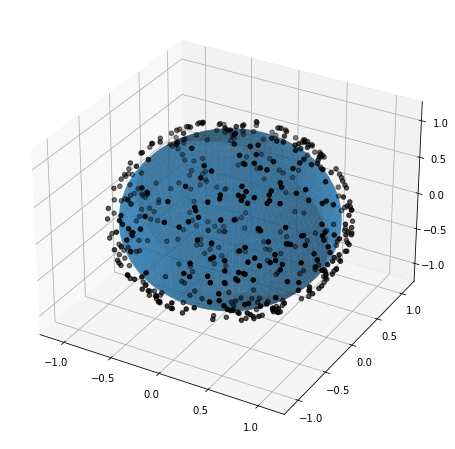

Iter  9
  Time orientations sampling = 1.69968581199646
  sgd epoch 0: mean sampled gradient = 0.0009092437154809223
  sgd epoch 50: mean sampled gradient = 1.7985195238568437e-05
  sgd epoch 100: mean sampled gradient = 3.0238326814237992e-05
  sgd epoch 150: mean sampled gradient = 6.314298356896958e-06
  Time vol optimisation = 16.193963766098022
Iter  10
  Time orientations sampling = 1.7432172298431396
  sgd epoch 0: mean sampled gradient = 0.0010689462835842196
  sgd epoch 50: mean sampled gradient = 7.161040046586662e-05
  sgd epoch 100: mean sampled gradient = 1.5188066581641922e-05
  sgd epoch 150: mean sampled gradient = 7.153265899465635e-05
  Time vol optimisation = 14.938401222229004
Iter  11
  Time orientations sampling = 1.7266521453857422
  sgd epoch 0: mean sampled gradient = 0.001036098830460059
  sgd epoch 50: mean sampled gradient = 7.936042748339245e-05
  sgd epoch 100: mean sampled gradient = 3.360152477769195e-05
  sgd epoch 150: mean sampled gradient = 2.9302127

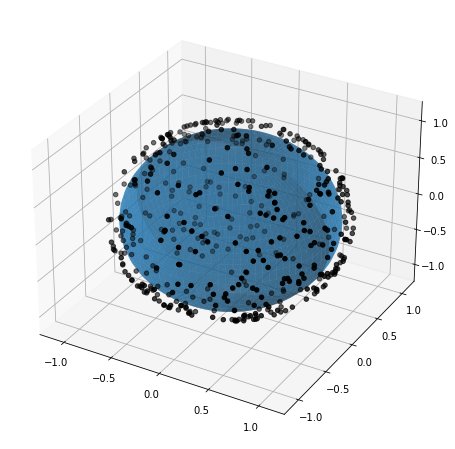

Iter  17
  Time orientations sampling = 1.7355287075042725
  sgd epoch 0: mean sampled gradient = 0.001020800158516193
  sgd epoch 50: mean sampled gradient = 6.507489453647099e-05
  sgd epoch 100: mean sampled gradient = 4.837194660748462e-05
  sgd epoch 150: mean sampled gradient = 3.465221068502911e-05
  Time vol optimisation = 15.877251625061035
Iter  18
  Time orientations sampling = 3.0397064685821533
  sgd epoch 0: mean sampled gradient = 0.0009460820275987549
  sgd epoch 50: mean sampled gradient = 2.7345213793066035e-05
  sgd epoch 100: mean sampled gradient = 3.412788721032879e-05
  sgd epoch 150: mean sampled gradient = 2.770292535641044e-05
  Time vol optimisation = 16.13726258277893
Iter  19
  Time orientations sampling = 1.7573130130767822
  sgd epoch 0: mean sampled gradient = 0.0009719366125388059
  sgd epoch 50: mean sampled gradient = 1.6393644823100694e-05
  sgd epoch 100: mean sampled gradient = 7.222587959912523e-05
  sgd epoch 150: mean sampled gradient = 2.289237

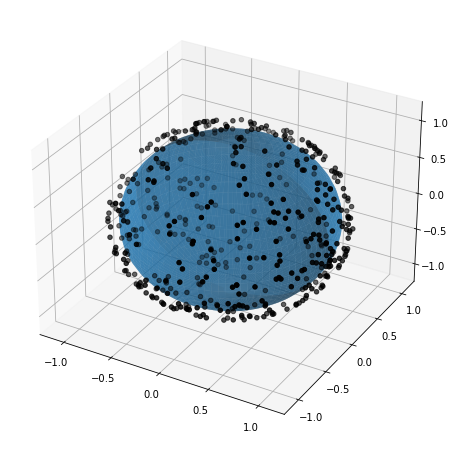

Iter  25
  Time orientations sampling = 1.7976791858673096
  sgd epoch 0: mean sampled gradient = 0.0005357072639656893
  sgd epoch 50: mean sampled gradient = 0.00010926790693438315
  sgd epoch 100: mean sampled gradient = 6.679650883110774e-06
  sgd epoch 150: mean sampled gradient = 4.6275682784970754e-05
  Time vol optimisation = 22.75257134437561
Iter  26
  Time orientations sampling = 1.8047988414764404
  sgd epoch 0: mean sampled gradient = 0.0005361402673437958
  sgd epoch 50: mean sampled gradient = 3.069999884848678e-05
  sgd epoch 100: mean sampled gradient = 7.836639819610634e-05
  sgd epoch 150: mean sampled gradient = 8.594669612831271e-06
  Time vol optimisation = 24.061241149902344
Iter  27
  Time orientations sampling = 1.7927212715148926
  sgd epoch 0: mean sampled gradient = 0.0004763763749821673
  sgd epoch 50: mean sampled gradient = 9.80450124701273e-05
  sgd epoch 100: mean sampled gradient = 2.9488185365608455e-05
  sgd epoch 150: mean sampled gradient = 2.38657

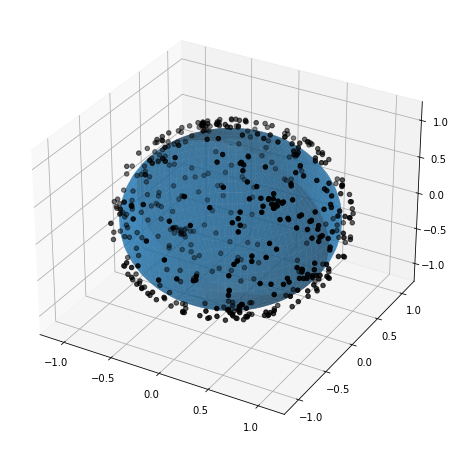

Iter  33
  Time orientations sampling = 1.830237865447998
  sgd epoch 0: mean sampled gradient = 0.00048011952757628413
  sgd epoch 50: mean sampled gradient = 4.430268085428547e-05
  sgd epoch 100: mean sampled gradient = 7.529459484104177e-07
  sgd epoch 150: mean sampled gradient = 1.9655864264632592e-05
  Time vol optimisation = 29.502852201461792
Iter  34
  Time orientations sampling = 1.8664438724517822
  sgd epoch 0: mean sampled gradient = 0.00046671510885530225
  sgd epoch 50: mean sampled gradient = 1.089676850181272e-05
  sgd epoch 100: mean sampled gradient = 1.2130371346184919e-05
  sgd epoch 150: mean sampled gradient = 1.5627072557658373e-05
  Time vol optimisation = 29.635109186172485
Iter  35
  Time orientations sampling = 1.8659052848815918
  sgd epoch 0: mean sampled gradient = 0.00046482922346099547
  sgd epoch 50: mean sampled gradient = 4.0343648711627876e-05
  sgd epoch 100: mean sampled gradient = 1.5122426028694021e-05
  sgd epoch 150: mean sampled gradient = 5

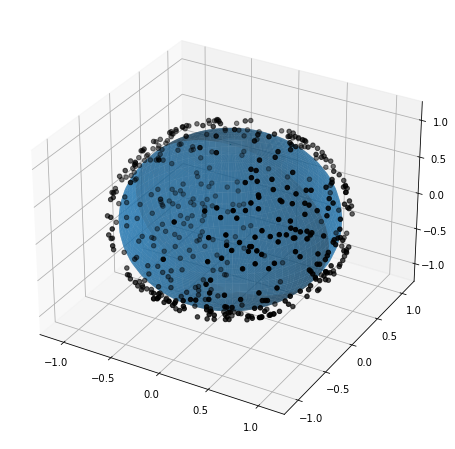

Iter  41
  Time orientations sampling = 1.8832852840423584
  sgd epoch 0: mean sampled gradient = 0.0004030576587643208
  sgd epoch 50: mean sampled gradient = 1.1261901732748373e-05
  sgd epoch 100: mean sampled gradient = 1.1276623305129805e-05
  sgd epoch 150: mean sampled gradient = 8.715526760763442e-06
  Time vol optimisation = 35.3064649105072
Iter  42
  Time orientations sampling = 1.8775601387023926
  sgd epoch 0: mean sampled gradient = 0.00039270221810830473
  sgd epoch 50: mean sampled gradient = 4.209722744872075e-05
  sgd epoch 100: mean sampled gradient = 1.1038857235549642e-05
  sgd epoch 150: mean sampled gradient = 4.103843348425947e-06
  Time vol optimisation = 34.9697482585907
Iter  43
  Time orientations sampling = 1.8974440097808838
  sgd epoch 0: mean sampled gradient = 0.00041307679309379855
  sgd epoch 50: mean sampled gradient = 9.841383715939772e-07
  sgd epoch 100: mean sampled gradient = 6.359265667789308e-06
  sgd epoch 150: mean sampled gradient = 1.49987

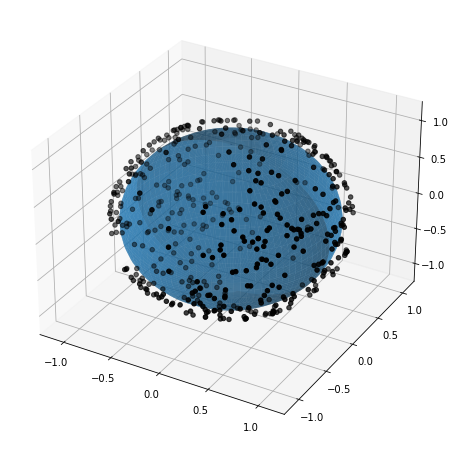

Iter  49
  Time orientations sampling = 1.9348933696746826
  sgd epoch 0: mean sampled gradient = 0.0002124190793604851
  sgd epoch 50: mean sampled gradient = 1.5034179011972423e-06
  sgd epoch 100: mean sampled gradient = 2.186654192745601e-06
  sgd epoch 150: mean sampled gradient = 5.313539842313523e-06
  Time vol optimisation = 45.716830253601074
Iter  50
  Time orientations sampling = 1.9635868072509766
  sgd epoch 0: mean sampled gradient = 0.00021524839031943
  sgd epoch 50: mean sampled gradient = 3.2367011339390153e-06
  sgd epoch 100: mean sampled gradient = 1.8127664650990933e-05
  sgd epoch 150: mean sampled gradient = 6.7154365455420376e-06
  Time vol optimisation = 45.764543533325195
Iter  51
  Time orientations sampling = 2.003232955932617
  sgd epoch 0: mean sampled gradient = 0.0002357930820424936
  sgd epoch 50: mean sampled gradient = 1.1800313204958453e-05
  sgd epoch 100: mean sampled gradient = 1.8902965926465152e-05
  sgd epoch 150: mean sampled gradient = 4.333

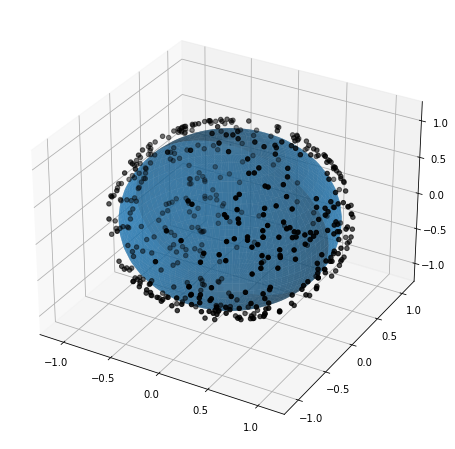

Iter  57
  Time orientations sampling = 3.296147346496582
  sgd epoch 0: mean sampled gradient = 0.00018000238811853716
  sgd epoch 50: mean sampled gradient = 1.3886988481654264e-05
  sgd epoch 100: mean sampled gradient = 8.62742860101117e-06
  sgd epoch 150: mean sampled gradient = 3.9080476319927465e-06
  Time vol optimisation = 50.00597167015076


In [78]:
N_samples = 100000
N_iter = 100

dr = 0.005
radius = 0.01
#radius = 0.03
alpha = 1e-4 # or leave it 1e-6

use_sgd = True

N_cg_iter = 101

N_sgd_iter = 151
batch_size = 1000
learning_rate = 1000
P = None

if use_sgd:
    N_vol_iter = N_sgd_iter
else:
    N_vol_iter = N_cg_iter

out_dir = '../data/relion/'
imgs_f = imgs_f.reshape([N, nx*nx])

v_rec, angles_rec = ab_initio(project, imgs_f, shifts, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius, dr, alpha, 'tri', True, True, True, out_dir)

In [79]:
v_rec.shape

(32, 32, 32)

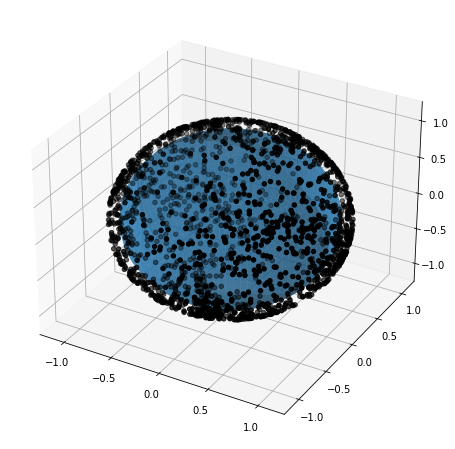

In [80]:
plot_angles(angles_rec[:2000])

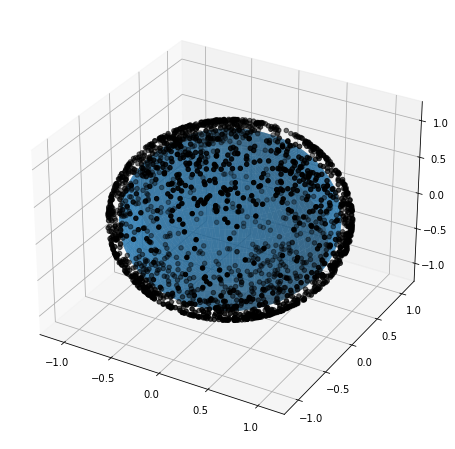

In [51]:
plot_angles(angles_rec[:2000])

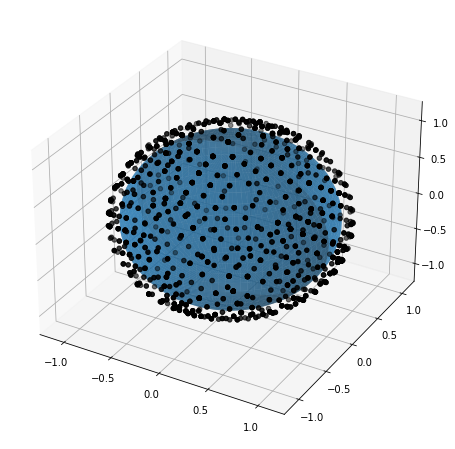

In [30]:
plot_angles(angles[:2000])

### CG

In [81]:
#v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
v0 = jnp.zeros([nx,nx,nx])* 1j
N_iter = 151

N2 = jnp.floor(N/2).astype(jnp.int64)
#N2 = 10000
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_rec[:N2], shifts[:N2], ctf_params[:N2], imgs_f[:N2], v0.shape)

In [82]:
vcg1, _ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = 0.04942208995393666
  cg iter 50 ||r|| = 0.00014374120590601166
  cg iter 100 ||r|| = 0.0001414947846836436
  cg iter 150 ||r|| = 0.0001298809377062597


In [58]:
#AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles[N2:], shifts[N2:], ctf_params[N2:], imgs_f[N2:], v0.shape)

#vcg2, _ = conjugate_gradient(AA1, Ab1, vcg1, 100, verbose = True)

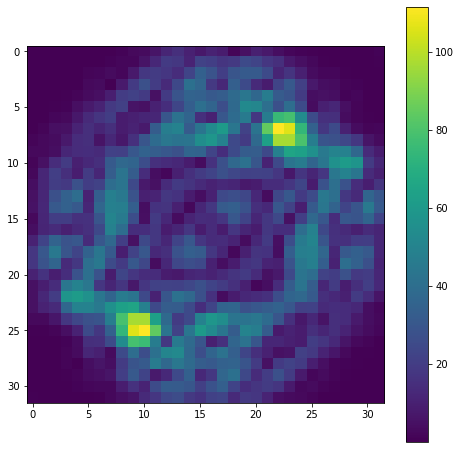

In [83]:
i = 110
s0 = slice_func(vcg1, angles[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

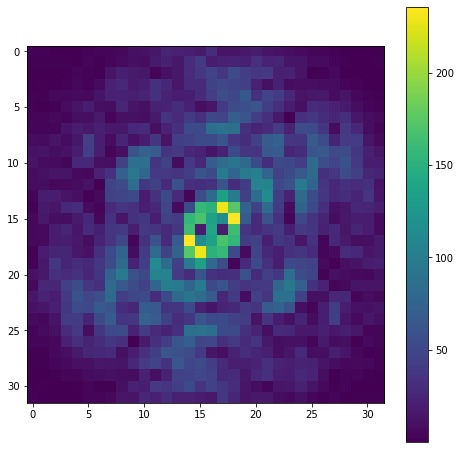

In [84]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vcg1[:,0,:]))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

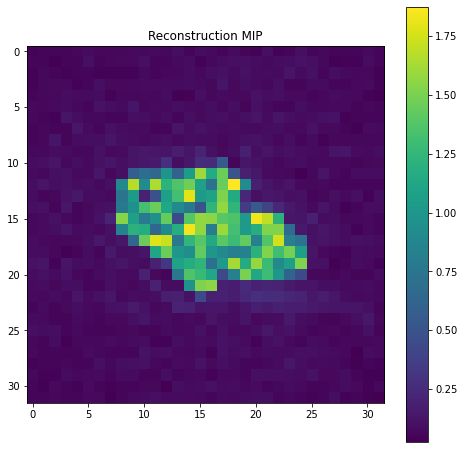

In [85]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [86]:
vr1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))) 

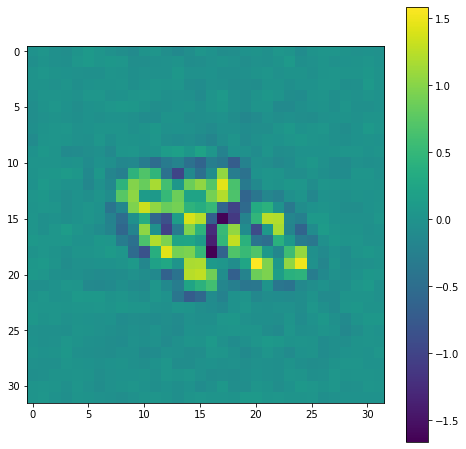

In [87]:
plt.imshow(vr1[:,:,16]); plt.colorbar()

### Write volume to file

In [88]:
with mrcfile.new('../data/reconstruction_data_32_angles_rec.mrc', overwrite=True) as mrc:
    mrc.set_data(vr1.astype(np.float32))

### FSC, orientations, standard deviation for each voxel etc

In [29]:
vcg2=vcg1

In [30]:
#dr = 0.01
dr = 0.05
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr)


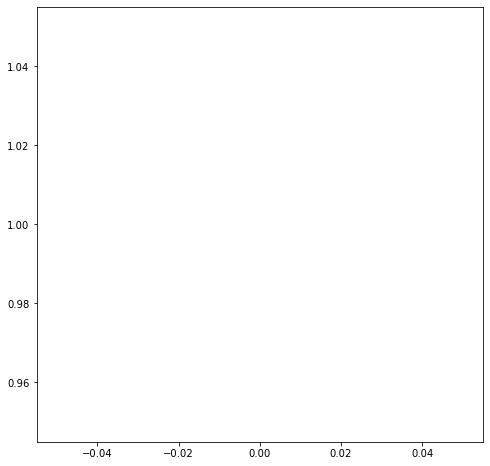

In [31]:
plt.plot(res,fsc)

In [17]:
#points_v_tri = points_orientations_tri(angles[:50], x_grid[1])
points_v_nn = points_orientations_nn(angles[:50], x_grid[1])

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

In [ ]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))))); plt.colorbar()

### SGD

### Preconditioner

0.001996007984031936
1.0


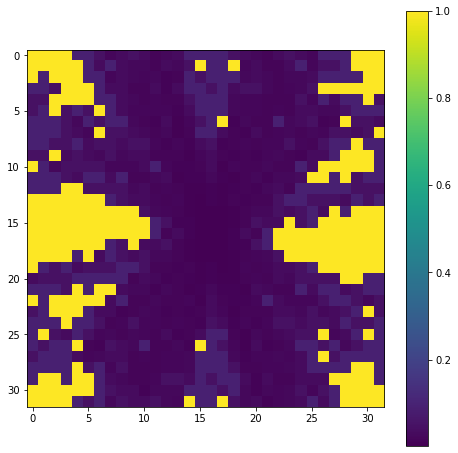

In [18]:
points_v_nn.shape
P = points_v_nn
P += 0.1
P = 1/P  * mask

P = P/jnp.max(P)

plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))

In [89]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
#v0 = jnp.zeros([nx,nx,nx])* 1j

batch_size = 1000
N_epoch = 151
number_of_batches = N/batch_size
learning_rate = 10000
#learning_rate = 10000 # <- with normalized precon
P = None

sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_batched, angles_rec, shifts, ctf_params, imgs_f)
vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, verbose = True)
            
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(vgd, angles, shifts, ctf_params, imgs_f)))
print("Relative error with CG = ", jnp.max(jnp.abs((vgd - vcg1)/jnp.max(vcg1))))

  sgd epoch 0: mean sampled gradient = 8.06701383664854e-06
  sgd epoch 50: mean sampled gradient = 3.386360932361974e-06
  sgd epoch 100: mean sampled gradient = 4.058610073292043e-06
  sgd epoch 150: mean sampled gradient = 6.632099942719963e-06
Final loss function (over all data) =  118939.48777851061
Relative error with CG =  0.25668048917778813


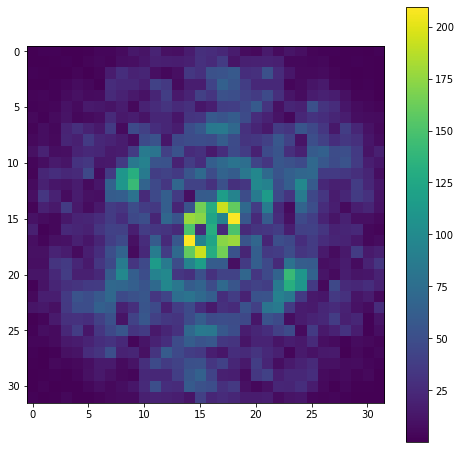

In [90]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgd[:,0,:]))); plt.colorbar()

In [91]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgd)))

Text(0.5, 1.0, 'Reconstruction MIP')

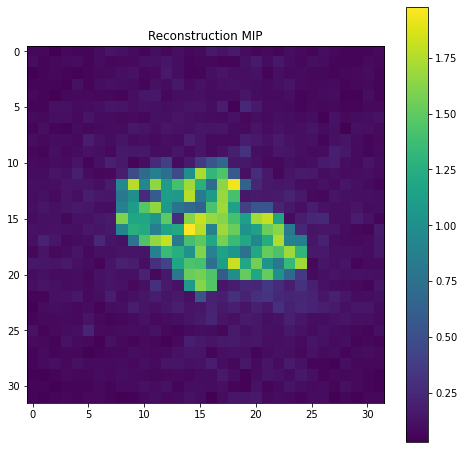

In [92]:
mip_z(vr_sgd)
plt.colorbar()
plt.title('Reconstruction MIP')

In [93]:
with mrcfile.new('../data/reconstruction_data_sgd.mrc', overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))